In [1]:
%load_ext lab_black

# Identifying sets of key players in a social network (docs/cmotkeyplayer.pdf) (http://www.casos.cs.cmu.edu/events/summer_institute/2006/reading_list/borgatti/Borgatti_Identifying_Sets.pdf)

# KPP-NEG algorithm

## KPP-NEG is defined as the identification of key players for the purpose of disrupting or fragmenting the network by removing the key nodes.

The first key player problem is defined in terms of the extent to which the network depends on its key players to maintain its cohesiveness. 
I refer to this as the “Key Player Problem/Negative” (KPP-Neg) because we measure importance in the breach—the amount of reduction in cohesiveness of the network that would occur if the nodes were not present. 
KPP-Neg arises in the public health context whenever we need to select a subset ofpopulation members to immunize or quarantine in order to optimally contain an epidemic. 
In the military or criminal justice context the problem arises when we need to select a small number of players in a criminal network to neutralize (e.g., by arresting, exposing or discrediting) in order to maximally disrupt the network’s ability to mount coordinated action.

A formal definition: 
Given a social network (represented as an undirected graph), find a set of k nodes (called a kp-set of order k) such that removing the kp-set would result in a residual network with the least possible cohesion.

KPP-Neg involves fragmenting a network into components, or, failing that, making path lengths between nodes so large as to be practically disconnected. 

fragmentation measure F

sizes ($s_{k}$) of each component (indexed by k)

number of nodes n

matrix R in which $r_{ij} = 1$ if i can reach j and $r_{ij} = 0$ otherwise

$F = 1 - \frac{2 \sum_{i}\sum_{j<i}r_{ij}}{n(n-1)}$

F achieves minimum value of 0 when the network consists of a single component

The DF measure is identical to F when all components are complete (i.e., each component is also a clique). However, when distances within components are greater than 1, the measure captures the relative cohesion of the components.

Like the F measure, DF achieves its maximum value of 1.0 when the graph consists entirely of isolates.

$\frac{1}{d_{ij}}$ provides a degree of reachability that varies from 0 to 1

$^{D}F=1-\frac{2\sum_{i>j}\frac{1}{d_{ij}}}{n(n-1)}$

The method, which is normally repeated using dozens of random starting sets:

1. Select k nodes at random to populate set S
2. Set F = fit using appropriate key player metric
3. For each node u in S and each node v not in S:
    a. $\Delta F =$ improvement in fit if u and v were swapped
4. Select pair with largest $\Delta F$
    a. if $\Delta F <=$ then terminate
    b. Else, swap pair with greatest improvement in fit and set $F = F + \Delta F$
5. Go to Step 3

## Key Player Calculation

In [2]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import sample

In [3]:
def calc_F_measure(input_graph):
    """Calculates the F-measure of a graph.

    Keyword arguments:
    graph -- The Networkx graph to calculate the measure on. It must be undirected.
"""

    n = input_graph.copy().number_of_nodes()

    all_pairs_shortest_path_lengths = [
        j for i, j in nx.all_pairs_shortest_path_length(input_graph.copy())
    ]

    [
        i.update((x, (1 / y) if y != 0 else 0) for x, y in i.items())
        for i in all_pairs_shortest_path_lengths
    ]  # reciprocal of each value

    F = 1 - (
        sum([sum(i.values()) for i in all_pairs_shortest_path_lengths]) / (n * (n - 1))
    )

    return F

In [4]:
p1 = pd.read_csv("../data/raw/PIRA Gill CSV/CSV/60_PERIOD1_NET.csv", index_col=0)
p2 = pd.read_csv("../data/raw/PIRA Gill CSV/CSV/60_PERIOD2_NET.csv", index_col=0)
p3 = pd.read_csv("../data/raw/PIRA Gill CSV/CSV/60_PERIOD3_NET.csv", index_col=0)
p4_5 = pd.read_csv("../data/raw/PIRA Gill CSV/CSV/60_PERIOD4_5_NET.csv", index_col=0)
p6 = pd.read_csv("../data/raw/PIRA Gill CSV/CSV/60_PERIOD6_NET.csv", index_col=0)

G1 = nx.from_pandas_adjacency(p1)
G2 = nx.from_pandas_adjacency(p2)
G3 = nx.from_pandas_adjacency(p3)
G4_5 = nx.from_pandas_adjacency(p4_5)
G6 = nx.from_pandas_adjacency(p6)

G = [G1, G2, G3, G4_5, G6]

In [5]:
# giant components
G1_giant = G1.subgraph(sorted(nx.connected_components(G1), key=len, reverse=True)[0])
G2_giant = G2.subgraph(sorted(nx.connected_components(G2), key=len, reverse=True)[0])
G3_giant = G3.subgraph(sorted(nx.connected_components(G3), key=len, reverse=True)[0])
G4_5_giant = G4_5.subgraph(
    sorted(nx.connected_components(G4_5), key=len, reverse=True)[0]
)
G6_giant = G6.subgraph(sorted(nx.connected_components(G6), key=len, reverse=True)[0])
G_giant = [G1_giant, G2_giant, G3_giant, G4_5_giant, G6_giant]

In [6]:
sub_outputs = pd.DataFrame()

k = 3

for index, graph in enumerate(G_giant.copy()):

    F_baseline = calc_F_measure(graph)

    graph_no = []
    F_baselines = []
    iteration = []
    key_players = []
    components = []
    Fs = []

    for i in range(10):

        graph_no.append(index)

        F_baselines.append(F_baseline)

        iteration.append(i)

        S = graph.subgraph(sample(graph.nodes, k)).copy()

        G_minus_S = graph.copy()
        G_minus_S.remove_nodes_from(S)  # nodes not in S

        F = calc_F_measure(G_minus_S)

        print(
            "Graph "
            + str(index)
            + ", iteration "
            + str(i)
            + " started (F is "
            + str(F)
            + ")"
        )

        while True:  # stop when improvements are too small

            u_best = -1
            v_best = -1
            delta_F_best = 0

            for u in S.nodes():

                for v in G_minus_S.nodes():

                    # swap out a node from G_minus_S into S_trial
                    S_trial = S.copy()
                    S_trial.add_node(v)
                    S_trial.remove_node(u)

                    # create G_minus_S_trial to see if the swap improves F
                    G_minus_S_trial = graph.copy()
                    G_minus_S_trial.remove_nodes_from(S_trial)

                    # see if the swap improves F, if so, add it to the best F variable (along with u and v)
                    F_new = calc_F_measure(G_minus_S_trial)
                    delta_F = F_new - F
                    if delta_F > delta_F_best:
                        u_best = u
                        v_best = v
                        delta_F_best = delta_F

            # if the best swap results in an improvement in F, update
            if delta_F_best >= 0.001:
                S.add_node(v_best)
                S.remove_node(u_best)
                G_minus_S = graph.copy()
                G_minus_S.remove_nodes_from(S)
                F = F + delta_F_best
                print(
                    "An improvement of "
                    + str(delta_F_best)
                    + " was made by swapping out "
                    + str(v_best)
                    + " and swapping in "
                    + str(u_best)
                    + ". F is now "
                    + str(F)
                )

            else:
                break

        Fs.append(F)

        diff = graph.copy()
        diff.remove_nodes_from(G_minus_S)
        key_players.append(list(diff.nodes()))

        components.append(nx.number_connected_components(G_minus_S))

        print(
            "Graph "
            + str(index)
            + ", iteration "
            + str(i)
            + " complete. F is now "
            + str(F)
            + ")"
        )

    sub_output = pd.DataFrame(
        {
            "graph_no": graph_no,
            "F_baselines": F_baselines,
            "iteration": iteration,
            "key_players": key_players,
            "components": components,
            "Fs": Fs,
        }
    )
    sub_outputs = sub_outputs.append(sub_output)
print("Done.")

Graph 0, iteration 0 started (F is 0.7452095381321187)
An improvement of 0.06284685422104785 was made by swapping out ZF434 and swapping in ZF1181. F is now 0.8080563923531665
An improvement of 0.048330307685146456 was made by swapping out ZF176 and swapping in ZF1269. F is now 0.856386700038313
An improvement of 0.029676312576312536 was made by swapping out ZF659 and swapping in ZF1367. F is now 0.8860630126146255
Graph 0, iteration 0 complete. F is now 0.8860630126146255)
Graph 0, iteration 1 started (F is 0.7496726434855467)
An improvement of 0.06664405200534229 was made by swapping out ZF434 and swapping in ZF29. F is now 0.816316695490889
An improvement of 0.04283848159009451 was made by swapping out ZF176 and swapping in ZF923. F is now 0.8591551770809835
An improvement of 0.026907835533641955 was made by swapping out ZF659 and swapping in ZF1322. F is now 0.8860630126146255
Graph 0, iteration 1 complete. F is now 0.8860630126146255)
Graph 0, iteration 2 started (F is 0.729606405

In [10]:
sub_outputs

,graph_no,F_baselines,iteration,key_players,components,Fs,key_players_string
0,0,0.731405,0,"[ZF659, ZF434, ZF176]",21,0.886063,"ZF659,ZF434,ZF176"
1,0,0.731405,1,"[ZF659, ZF434, ZF176]",21,0.886063,"ZF659,ZF434,ZF176"
2,0,0.731405,2,"[ZF659, ZF434, ZF176]",21,0.886063,"ZF659,ZF434,ZF176"
3,0,0.731405,3,"[ZF659, ZF434, ZF176]",21,0.886063,"ZF659,ZF434,ZF176"
4,0,0.731405,4,"[ZF659, ZF434, ZF176]",21,0.886063,"ZF659,ZF434,ZF176"
5,0,0.731405,5,"[ZF659, ZF434, ZF176]",21,0.886063,"ZF659,ZF434,ZF176"
6,0,0.731405,6,"[ZF659, ZF434, ZF176]",21,0.886063,"ZF659,ZF434,ZF176"
7,0,0.731405,7,"[ZF659, ZF434, ZF176]",21,0.886063,"ZF659,ZF434,ZF176"
8,0,0.731405,8,"[ZF659, ZF434, ZF176]",21,0.886063,"ZF659,ZF434,ZF176"
9,0,0.731405,9,"[ZF659, ZF434, ZF176]",21,0.886063,"ZF659,ZF434,ZF176"


In [8]:
# make a new column with the key players as a string, for convenience.
sub_outputs["key_players_string"] = [
    ",".join(map(str, l)) for l in sub_outputs["key_players"]
]

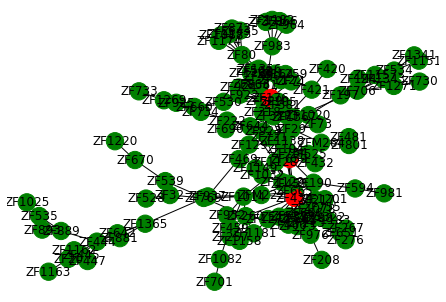

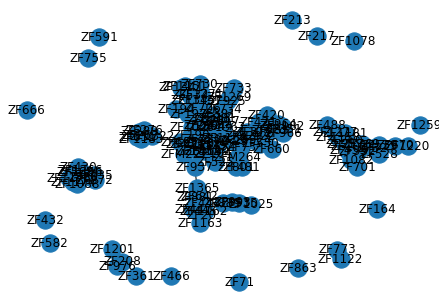

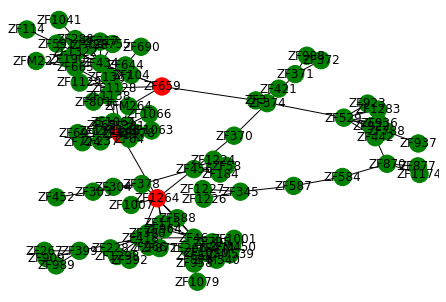

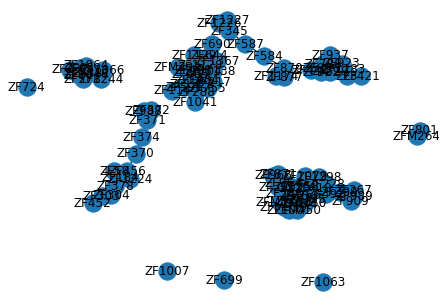

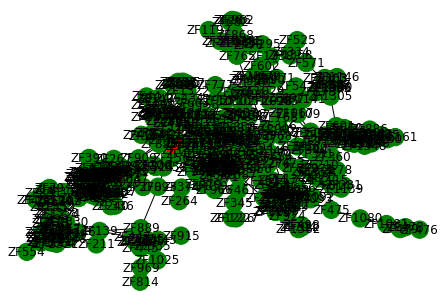

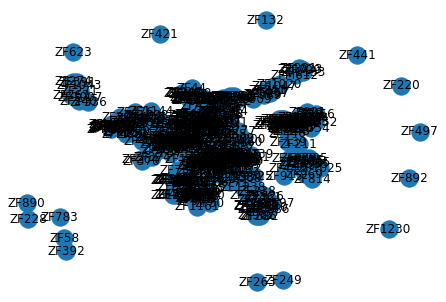

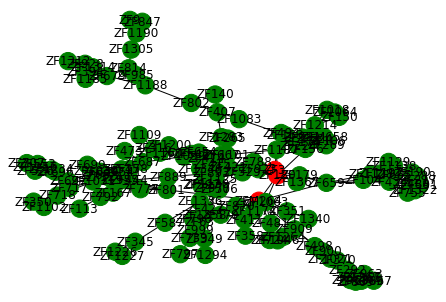

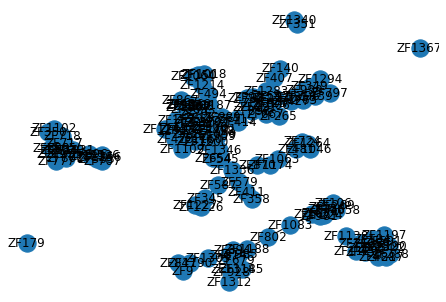

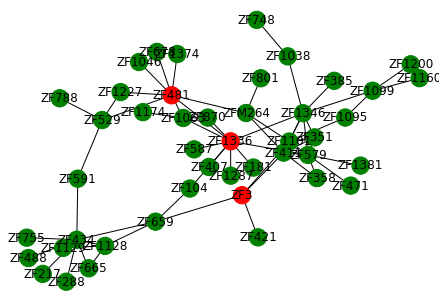

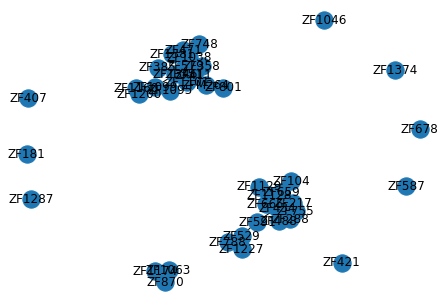

In [65]:
# plot each giant component and show the key players
for index, graph in enumerate(G_giant):

    color_map = []
    for node in graph:
        sub_outputs_graph = sub_outputs[sub_outputs["graph_no"] == index]
        sub_outputs_best_F = sub_outputs_graph[
            sub_outputs_graph["Fs"] == sub_outputs_graph["Fs"].max()
        ]
        sub_outputs_best_FC = sub_outputs_best_F[
            sub_outputs_best_F["components"] == sub_outputs_best_F["components"].max()
        ].head(1)
        if node in sub_outputs_best_FC["key_players"].values[0]:
            color_map.append("red")
        else:
            color_map.append("green")
    nx.draw(graph, nx.spring_layout(graph), node_color=color_map, with_labels=True)
    plt.show()

    graph_temp = graph.copy()
    graph_temp.remove_nodes_from(
        sub_outputs[
            sub_outputs["key_players_string"].isin(
                list(
                    sub_outputs[sub_outputs["graph_no"] == index][
                        "key_players_string"
                    ].agg("mode")
                )
            )
        ]
        .sort_values("components", ascending=False)
        .head(1)["key_players"]
        .values[0]
    )

    color_map = []
    for node in graph_temp:
        color_map.append("green")
    nx.draw(graph_temp, nx.spring_layout(graph_temp), with_labels=True)
    plt.show()